# Creating a Scheduler Object Using Johnsons Algorithm

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class Scheduler:
  def __init__(self, jobs_dataframe):
    self.jobs = jobs_dataframe
  
  def johnsons_algorithm(self):
    """Sorts jobs according to Johnsons algorithm/rule"""
    n = len(self.jobs)
    jobs_temp = self.jobs.copy()
    order = [0 for i in range(n)]
    for i in range(n):
      Amin = jobs_temp.P_A.min()
      Bmin = jobs_temp.P_B.min()
      Amin_index = jobs_temp.P_A.idxmin()
      Bmin_index = jobs_temp.P_B.idxmin()
      if Amin <= Bmin:
        i_del = Amin_index
        i_order = order.index(0)
        job_index = Amin_index
      else:
        i_del = Bmin_index
        i_order = n -  1 - order[::-1].index(0)
        job_index = Bmin_index
      order[i_order] = job_index
      jobs_temp = jobs_temp.drop(i_del)
    self.jobs = pd.DataFrame([jobs.loc[i] for i in order])

  def schedule_start_end(self):
    """Calculates start and end times/dates for each job"""
    n = len(self.jobs)
    schedule = self.jobs.copy()
    schedule['start_A'] = np.zeros(n)
    schedule['end_A'] = np.zeros(n)
    schedule['start_B'] = np.zeros(n)
    schedule['end_B'] = np.zeros(n)
    for i in range(n):
      if i == 0:
        schedule.start_A.iloc[i] = 0
      else:
        schedule.start_A.iloc[i] = schedule.end_A.iloc[i - 1]
      schedule.end_A.iloc[i] = schedule.start_A.iloc[i] + schedule.P_A.iloc[i]
      if i == 0:
        schedule.start_B.iloc[i] = schedule.end_A.iloc[i]
      else:
        schedule.start_B.iloc[i] = max([schedule.end_A.iloc[i], schedule.end_B.iloc[i - 1]])
      schedule.end_B.iloc[i] = schedule.start_B.iloc[i] + schedule.P_B.iloc[i]
    self.schedule = schedule

  def plot_schedule(self, color_map=plt.cm.Set3, plot_size=(15, 5)):
    """Plots the production schedule as a Gantt chart"""
    fig, ax = plt.subplots(figsize=plot_size)
    colors = iter([color_map(i) for i in range(20)])
    for index, row in self.schedule.iterrows():
      xs = [(row.start_A, row.end_A), (row.start_B, row.end_B)]
      xmins = np.array([row.start_A, row.start_B])
      xmaxs = np.array([row.end_A, row.end_B])
      cs = xmins + (xmaxs - xmins) / 2
      ys = [2, 1]
      ax.hlines(
          y=ys,
          xmin=xmins,
          xmax=xmaxs,
          linestyle='solid',
          linewidth=50,
          label=index,
          colors=[next(colors)])
      for c, y in zip(cs, ys):
        ax.text(
            x=c,
            y=y,
            s=index,
            ha='center',
            va='center')
    plt.yticks([1, 2], ['Machine_B', 'Machine_A'])
    plt.ylim(0, 3)
    ax.set_xlabel('Time')
    ax.set_ylabel('Resource')
    ax.set_title('Productioon schedule')
    ax.grid(axis='x')
    plt.show()
  
  def get_metrics(self):
    """Calculates metrics based on the production schedule"""
    idle_A = 0
    idle_B = 0
    n = len(self.schedule)
    for i in range(n):
      if i > 0 and i < n - 1:
        idle_A += self.schedule.start_A.iloc[i] - self.schedule.end_A.iloc[i - 1]
      elif i == n - 1:
        idle_A += self.schedule.end_B.iloc[i] - self.schedule.end_A.iloc[i]
      if i == 0:
        idle_B += self.schedule.start_B.iloc[i]
      else:
        idle_B += self.schedule.start_B.iloc[i] - self.schedule.end_B.iloc[i - 1]
    metrics = ['makespan', 'average_flow_A', 'average_flow_B',
               'idle_time_A', 'idle_time_B']
    values = [self.schedule.end_B.iloc[-1], np.mean(self.schedule.end_A),
              np.mean(self.schedule.end_B), idle_A, idle_B]
    self.metrics = pd.DataFrame(data=values, index=metrics, columns=['value'])

#Creating a Scheduler

In [8]:
jobs = pd.DataFrame(
    dict(
        P_A = [8, 8, 3, 9, 8, 2, 6, 6, 18, 20],
        P_B = [2.5, 2.5, 13, 6, 7, 14, 2, 2, 14, 11],
    ),
    index = ['A1', 'A2', 'B', 'C', 'D', 'E', 'F1', 'F2', 'G', 'H']
)

s = Scheduler(jobs)
s.jobs

,P_A,P_B
A1,8,2.5
A2,8,2.5
B,3,13.0
C,9,6.0
D,8,7.0
E,2,14.0
F1,6,2.0
F2,6,2.0
G,18,14.0
H,20,11.0


#Sorting the Jobs

In [9]:
s.johnsons_algorithm()
s.jobs

,P_A,P_B
E,2.0,14.0
B,3.0,13.0
G,18.0,14.0
H,20.0,11.0
D,8.0,7.0
C,9.0,6.0
A2,8.0,2.5
A1,8.0,2.5
F2,6.0,2.0
F1,6.0,2.0


#Generating a Schedule

In [10]:
s.schedule_start_end()
s.schedule

,P_A,P_B,start_A,end_A,start_B,end_B
E,2.0,14.0,0.0,2.0,2.0,16.0
B,3.0,13.0,2.0,5.0,16.0,29.0
G,18.0,14.0,5.0,23.0,29.0,43.0
H,20.0,11.0,23.0,43.0,43.0,54.0
D,8.0,7.0,43.0,51.0,54.0,61.0
C,9.0,6.0,51.0,60.0,61.0,67.0
A2,8.0,2.5,60.0,68.0,68.0,70.5
A1,8.0,2.5,68.0,76.0,76.0,78.5
F2,6.0,2.0,76.0,82.0,82.0,84.0
F1,6.0,2.0,82.0,88.0,88.0,90.0


#Calculating Metrics

In [11]:
s.get_metrics()
s.metrics

,value
makespan,90.0
average_flow_A,49.8
average_flow_B,59.3
idle_time_A,2.0
idle_time_B,16.0


#Visualizing the Schedule

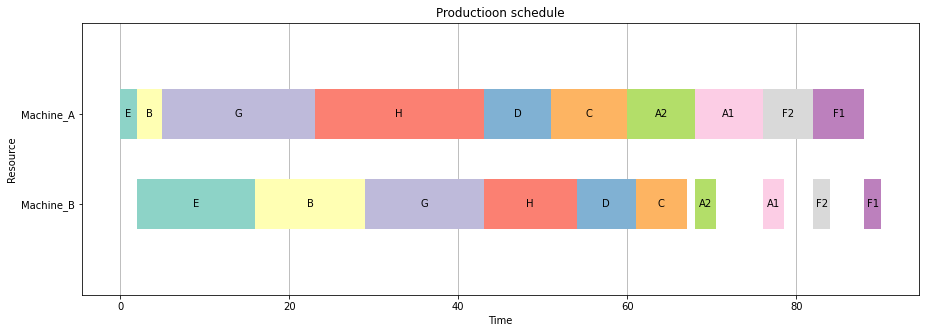

In [12]:
s.plot_schedule()